In [1]:
# Import necessary libraries
import os
import warnings
import logging
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model as tfkModel
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import register_keras_serializable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from keras.callbacks import Callback
import IPython.display as display
from PIL import Image
import matplotlib.gridspec as gridspec
import json
import keras_cv
from tqdm import tqdm
import cv2 as cv 

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

tf.random.set_seed(42)

print("Tensorflow version: ", tf.__version__)
print("Keras version: ", tfk.__version__)
print("Is GPU detected: ", len(tf.config.list_physical_devices('GPU'))>0)
print("Is TPU detected: ", len(tf.config.list_physical_devices('TPU'))>0)

Tensorflow version:  2.17.1
Keras version:  3.5.0
Is GPU detected:  True
Is TPU detected:  False


In [2]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [3]:
# Setting che correct strategy for TPU / batch sizes
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

Running on 1 replicas
Num GPUs Available:  1
Num TPUs Available:  0


In [4]:
batch_size = 32
if numTPU != 0:
    batch_size = strategy.num_replicas_in_sync * 32

print(f"Batch size: {batch_size}")

Batch size: 32


In [5]:
tfk.mixed_precision.set_global_policy("mixed_bfloat16")

## Load dataset

In [6]:
data = np.load('/kaggle/input/lung-cancer/Mohammad_Preprocessing/Mohammad_Preprocessing/train_set.npz')
# np.savez_compressed('/kaggle/working/dataset.npz', **data)
# data = np.load('/kaggle/working/dataset.npz')

full_slices = data['full_slices']
nodules = data['nodules']
tumor_classes = data['labels']

print("full_slices shape: ", full_slices.shape)
print("nodules shape: ", nodules.shape)
print("tumor_classes shape: ", tumor_classes.shape)

full_slices shape:  (3089, 512, 512, 3)
nodules shape:  (3089, 138, 138, 3)
tumor_classes shape:  (3089,)


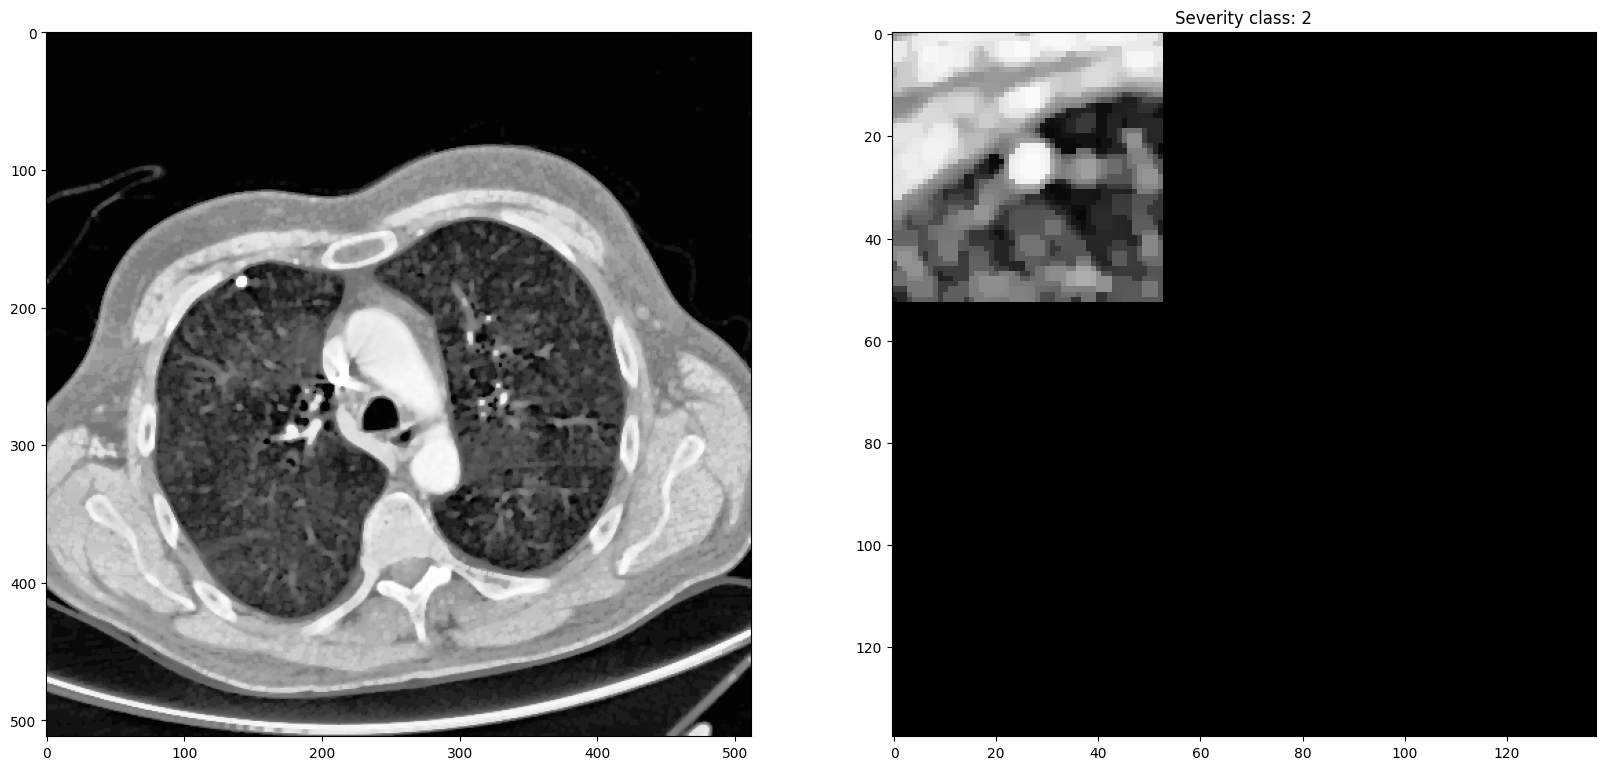

In [7]:
IMAGE_IDX = 0

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title(f"Severity class: {tumor_classes[IMAGE_IDX]}")

ax1.imshow(full_slices[IMAGE_IDX], cmap='gray')
ax2.imshow(nodules[IMAGE_IDX], cmap='gray')

plt.show()

# Data preprocessing

In [8]:
print(f'Min value: {np.min(full_slices)}')
print(f'Max value: {np.max(full_slices)}')
print("Contains NaN:", np.isnan(full_slices).any())
print("Contains Inf:", np.isinf(full_slices).any())

Min value: 0
Max value: 255
Contains NaN: False
Contains Inf: False


In [9]:
# Downscale images
full_slices = [cv.resize(image, (256, 256)) for image in full_slices]
full_slices = np.array(full_slices)

In [10]:
from sklearn.preprocessing import MinMaxScaler

num_images, height, width, channels = full_slices.shape
full_slices = full_slices.reshape(num_images, -1) 

scaler = MinMaxScaler(feature_range=(0, 1))
full_slices = scaler.fit_transform(full_slices)

full_slices = full_slices.reshape(num_images, height, width, channels)

In [11]:
print(f'Min value: {np.min(full_slices)}')
print(f'Max value: {np.max(full_slices)}')

Min value: 0.0
Max value: 1.0000000000000002


In [12]:
full_slices = full_slices * 255
full_slices = np.ceil(full_slices).astype('uint8')

In [13]:
print(f'Min value: {np.min(full_slices)}')
print(f'Max value: {np.max(full_slices)}')

Min value: 0
Max value: 255


In [14]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
kernel = np.ones((3, 3), np.uint8)

def img_enhancer(img):
    img = cv.medianBlur(img, 3)
    img = cv.equalizeHist(img)
    img = clahe.apply(img)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    return img

def plot_image(image, title='Image'):
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

def img_enhancer_logger(img):
    plot_image(img, 'Original')
    img = cv.medianBlur(img, 3)
    plot_image(img, 'Median Blur')
    img = cv.equalizeHist(img)
    plot_image(img, 'Equalized Hist')
    img = clahe.apply(img)
    plot_image(img, 'CLAHE')
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    plot_image(img, 'Morph')
    return img

In [15]:
# plt.title('Before "enhancements"')
# plt.imshow(full_slices[IMAGE_IDX], cmap='gray')
# plt.show()


# plt.title('After "enhancements"')
# img_enhancer_logger(full_slices[IMAGE_IDX])
# plt.show()

In [16]:
# Enhance the images
# processed_images = []
# for img in full_slices:
#     img = img_enhancer(img)
#     processed_images.append(img)

# full_slices = np.array(processed_images)

In [17]:
# subtract 1 from the class encoding because to_categorical expects starting index = 0
y_num = tumor_classes - 1
label_set = tfk.utils.to_categorical(y_num, num_classes=5)
label_set

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [18]:
def calculate_class_weight(Y):
    from sklearn.utils.class_weight import compute_class_weight

    y_integers = np.argmax(Y, axis=1)
    return compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)    

[1.14407407 0.91390533 0.76555143 0.99967638 1.37901786]


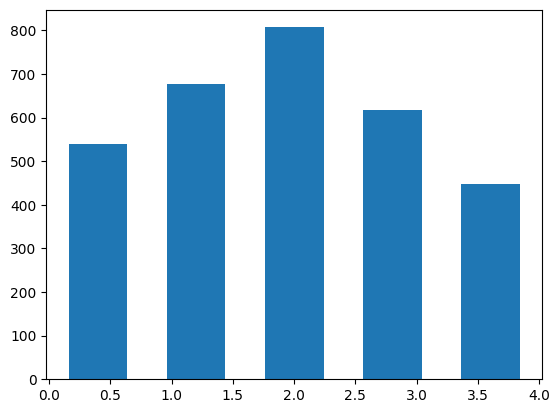

In [19]:
# Starting class weights (inverse frequencies)
class_weights = calculate_class_weight(label_set)

plt.hist(np.argmax(label_set, -1), bins=5,rwidth=0.6)
print(class_weights)

# d_class_weights = dict(enumerate(class_weights))

# import json # Just to prettify the debug
# print(json.dumps(d_class_weights, sort_keys=True, indent=1))

[0.755      1.20621302 1.01040892 1.31941748 0.91004464]
{
 "0": 0.755,
 "1": 1.2062130177514794,
 "2": 1.0104089219330854,
 "3": 1.3194174757281554,
 "4": 0.9100446428571428
}


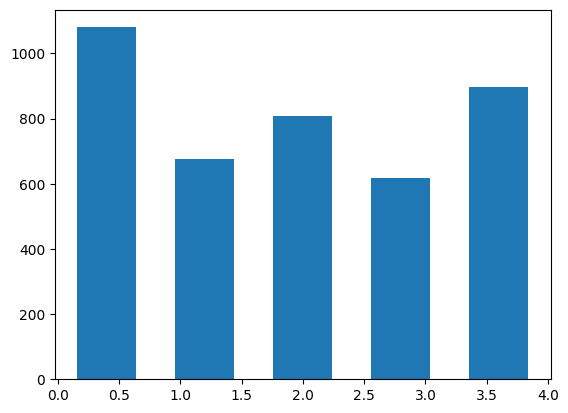

In [20]:
# Balance the dataset by applying random rotations
# full_slices = np.expand_dims(full_slices, -1)

X_bal, y_bal = [], []
X_bal.extend(full_slices)
y_bal.extend(y_num)

while class_weights[4] > 1 + 0.1:
    # Repeat this while last class (the minority one) is "infrequent"
    for x, y in zip(full_slices, label_set):
        
        # Apply augmentation if class is infrequent
        class_ = np.argmax(y)
        if class_weights[class_] > 1:
            # Just rotation to not mess up too much the image distribution (thankfully they're only slices of the CT) 
            x = tfkl.RandomRotation(0.9)(x)
            X_bal.append(x)
            y_bal.append(class_)
    
    # Recalculate weights
    class_weights = calculate_class_weight(tfk.utils.to_categorical(y_bal))

X_balanced, y_balanced = np.asarray(X_bal), np.asarray(y_bal)

plt.hist(np.argmax(tfk.utils.to_categorical(y_bal, num_classes=5), -1), bins=5,rwidth=0.6)
print(class_weights)

# These lines are now useless but ok
d_class_weights = dict(enumerate(class_weights))

import json # Just to prettify the debug
print(json.dumps(d_class_weights, sort_keys=True, indent=1))

In [21]:
X_balanced = np.array([cv.cvtColor(img.astype('uint8'), cv.COLOR_RGB2GRAY)[..., np.newaxis] for img in X_balanced])
print(X_balanced.shape)
print(y_balanced.shape)

(4077, 256, 256, 1)
(4077,)


In [22]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, shuffle=True, stratify=y_balanced)
# X_train, X_test, y_train, y_test = train_test_split(full_slices, label_set, test_size=0.3, shuffle=True, stratify=label_set)

X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

print("Training set shape: ", X_train.shape, y_train.shape)
print("Test set shape: ", X_test.shape, y_test.shape)

print("Train/Test mins ", np.min(X_train), np.min(X_test))
print("Train/Test maxs ", np.max(X_train), np.max(X_test))

Training set shape:  (2853, 256, 256, 1) (2853,)
Test set shape:  (1224, 256, 256, 1) (1224,)
Train/Test mins  0.0 0.0
Train/Test maxs  1.0 1.0


In [23]:
def perform_augmentation(X, Y, p):
    X_aug, y_aug = [], []
    for x, y in tqdm(zip(X, Y), total=len(X), desc="Augmenting data"):
        X_aug.append(x)
        y_aug.append(y)

        if np.random.random() < p: # random rotate the image and add it
            # It would be better to apply these independently
            x = tfkl.RandomRotation(0.9)(x)
            x = tfkl.RandomFlip()(x)
            x = tfkl.RandomTranslation(0.3, 0.3)(x)
            X_aug.append(x)
            y_aug.append(y)

    return np.asarray(X_aug), np.asarray(y_aug)

In [24]:
# Repeated training set augmentation for laughs
X_aug, y_aug = perform_augmentation(X_train, y_train, 0.75)
X_aug, y_aug = perform_augmentation(X_aug, y_aug, 0.2)

print("Augmented training set shape: ", X_aug.shape, y_aug.shape)

Augmenting data: 100%|██████████| 4974/4974 [00:41<00:00, 120.65it/s]


Augmented training set shape:  (5971, 256, 256, 1) (5971,)


In [25]:
batch_size = 8
input_shape=(256, 256, 1)
num_classes = 5
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 256  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

## Model definition

In [26]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [27]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Resized image (1, 256, 256, 3)
Image size: 256 X 256
Patch size: 8 X 8
Patches per image: 1024
Elements per patch: 192


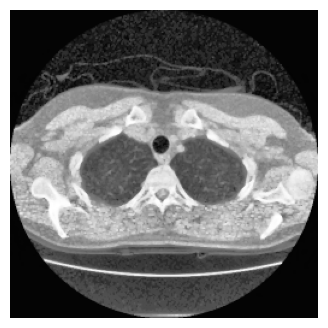

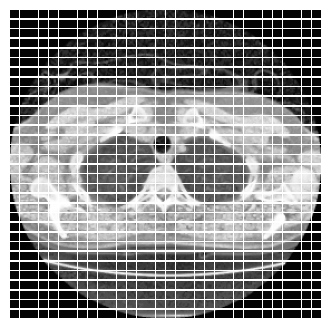

In [28]:
plt.figure(figsize=(4, 4))
image = full_slices[np.random.choice(range(full_slices.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

# resized_image = tf.image.rgb_to_grayscale(
#     ops.image.resize(
#         ops.convert_to_tensor([image]), size=(image_size, image_size)
#     )
# )

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)

print(f"Resized image {resized_image.shape}")
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, resized_image.shape[3]))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"), cmap='gray')
    plt.axis("off")

In [29]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        # print(f'PROJECTED PATCHES: {patch}')
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [30]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # print(f'Patches: {patches}, num_patches {num_patches}, proj_dim {projection_dim}')
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [31]:
# Custom callback class for real-time plotting
class RealTimePlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['accuracy'])
        self.val_acc.append(logs['val_accuracy'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        #self.ax_loss.set_ylim(top=2.5, bottom=0.0)
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Accuracy')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        self.ax_acc.set_title('Training and Validation Accuracy')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Accuracy')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

In [32]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max', 
    patience=50,
    restore_best_weights=True
)

realtime_plot = RealTimePlot()

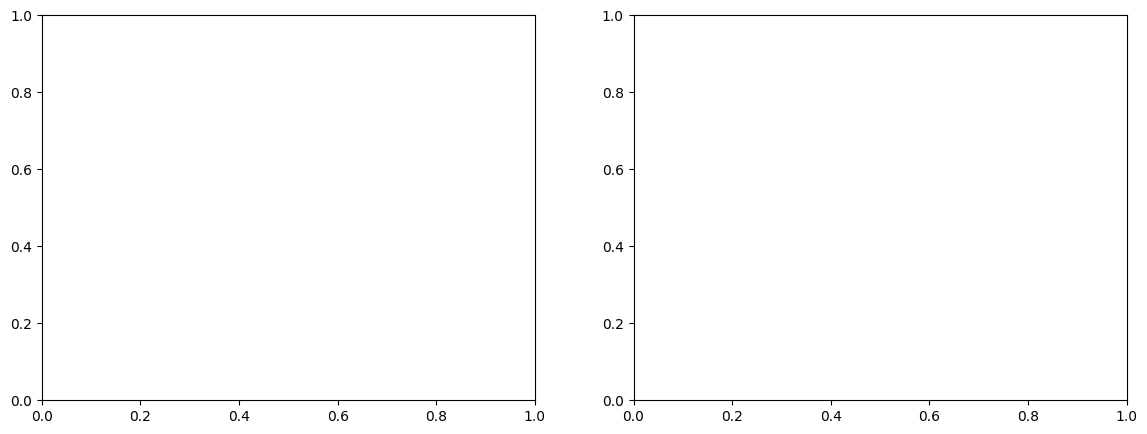

Epoch 1/10


In [ ]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/kaggle/working/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_aug,
        y=y_aug,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback, early_stopping, realtime_plot],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
# plot_history("top-5-accuracy")

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
print(X_test.shape)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
accuracy = round(test_accuracy, 4)
print(f'Test Accuracy: {accuracy}')

model.save(f"/kaggle/working/CustomCNN_{accuracy}.keras")

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

classes = [1, 2, 3, 4, 5]

predictions = model.predict(X_test)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annot, fmt=".4", xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()